In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
df = pl.read_parquet(
    "https://osf.io/emh23/download",
    use_pyarrow=True,
)


In [3]:
print(df.columns)


['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index', 'Run ID', 'Is Task Coding Site', 'Is Viability Site', 'Is Task Coding Site Cumulative Count', 'Is Viability Site Cumulative Count', 'Prev Is Task Coding Site Cumulative Count', 'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site', 'Prev Is Viability Site', 'Site', 'Has Task', 'has task', 'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP', 'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK', 'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS', 'Is Task Coding Site Delta', 'Is Viability Site Delta', 'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count', 'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK', 'Generation Born', 'Update Born']


In [4]:
df = df.with_columns(
    pl.col("Task").replace_strict(
        {
            "AND": False,  # 2,
            "ANDNOT": False,  # 3,
            "NAND": False,  # 1,
            "NOR": True,  # 4,
            "NOT": False,  # 1,
            "OR": False,  # 3,
            "ORNOT": False,  # 2,
            "XOR": True,  # 4,
            "EQUALS": True,  # 5,
        },
    ).alias(
        "Complex Components"
    )
)


/tmp/ipykernel_4172/862515880.py:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = df.with_columns(


In [5]:
df = df.with_columns(
    (
        pl.col("Complex Components")
        & pl.col("has task")
    ).alias(
        "Active Complex Components"
    )
)


In [6]:
df = df.with_columns(
    pl.col("Active Complex Components").any().over(
        ["Treatment", "Run ID", "Generation Born"],
    ).alias("Has Complex Components"),
)


In [7]:
df = df.with_columns(
    pl.col("Active Complex Components").sum().over(
        ["Treatment", "Run ID", "Generation Born", "Site"],
    ).alias("Num Complex Components"),
)


In [8]:
df = df.with_columns(
    pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
        ["Treatment", "Run ID", "Generation Born"],
    ).alias("SLIP_INSERTION_BOOL_MASK any"),
)


In [9]:
df = df.with_columns(
    pl.col("Is Task Coding Site").any().over(
        ["Treatment", "Run ID", "Generation Born", "Site"],
    )
    .alias("is any coding site"),
)


In [10]:
df = df.with_columns(
    pl.col("Is Task Coding Site Delta").sum().over(
        ["Treatment", "Run ID", "Generation Born"],
    )
    .alias("is task coding site delta sum"),
)


In [11]:
df = df.with_columns(
    pl.col("has task").sum().over(
        ["Treatment", "Run ID", "Generation Born", "Site"],
    )
    .alias("num tasks has"),
)


In [12]:
df = df.with_columns(
    pl.col("is any coding site").sum().over(
        ["Treatment", "Run ID", "Generation Born", "Task",],
    ).alias("num coding sites"),
)


In [13]:
dfx = df.group_by(
    ["Treatment", "Run ID", "Generation Born", "num tasks has", "num coding sites", "is task coding site delta sum", "SLIP_INSERTION_BOOL_MASK any", "Has Complex Components", "Num Complex Components"],
).agg(
    (
        (pl.col("delta has task") == 1).any() * 2
        + (pl.col("delta has task") == -1).any()
    ).replace_strict(
        {
            0: "No change",
            1: "Task loss",
            2: "Task gain",
            3: "Task gain and loss",
        },
    )
    .alias("task change"),
)


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.png


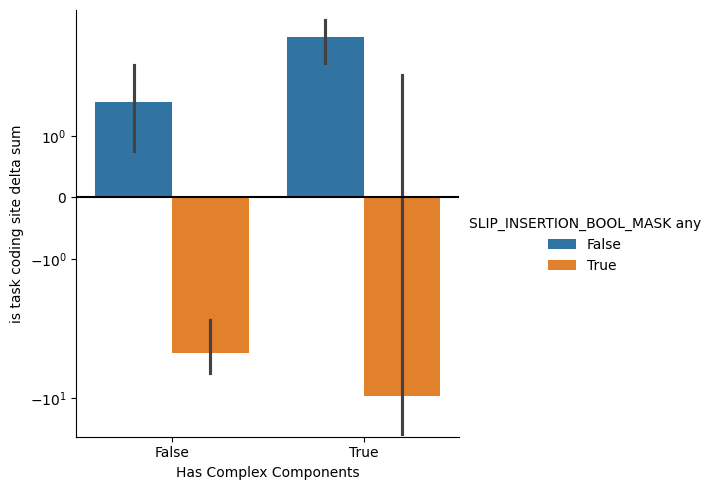

In [14]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+mut=poisson+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+mut=poisson+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.png


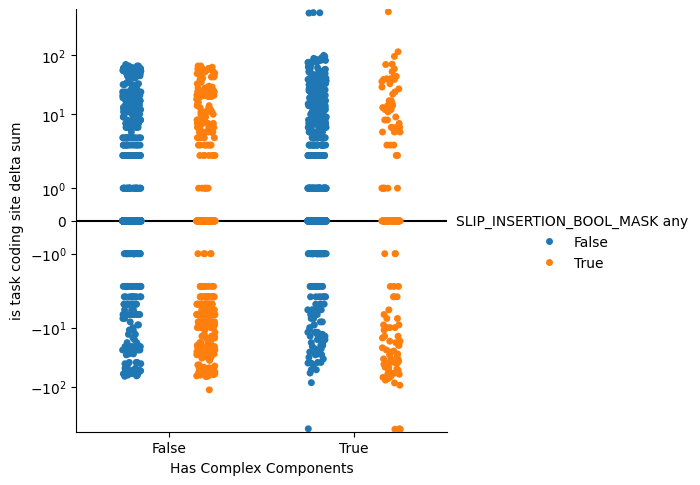

In [15]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="strip",
    dodge=True,
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=has-complex-components+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=has-complex-components+ext=.png


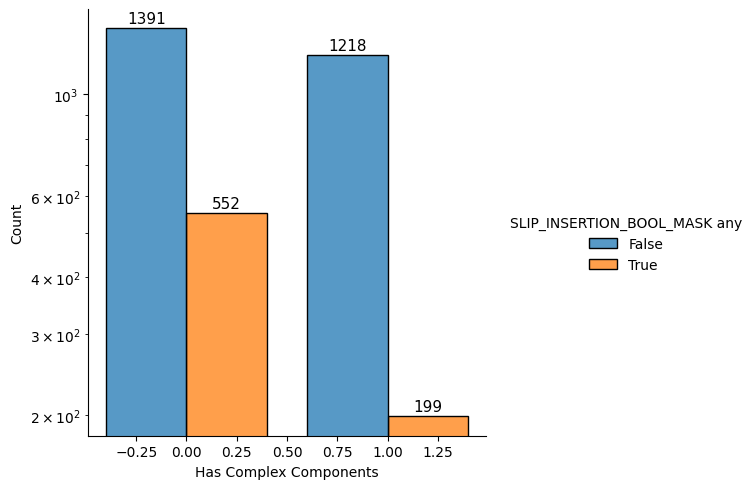

In [16]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,
    teeplot_outattrs={"mut": "poisson"},
)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/hue=has-complex-components+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=num-tasks-has+ext=.pdf


teeplots/hue=has-complex-components+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=num-tasks-has+ext=.png


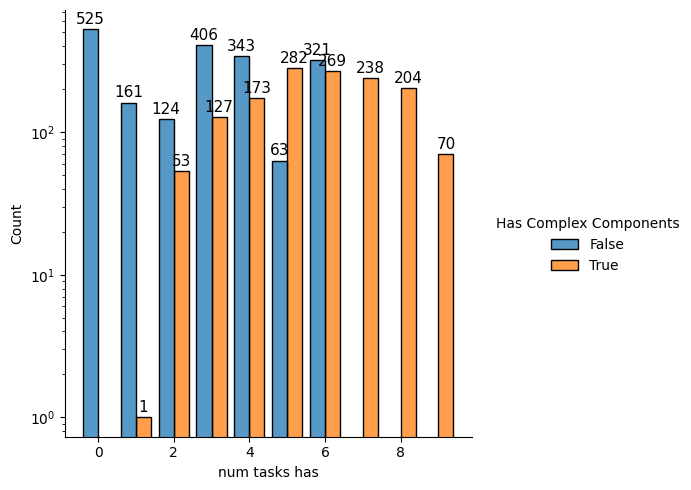

In [17]:
saveit, g = tp.tee(
    sns.displot,
    hue="Has Complex Components",
    kind="hist",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,
    teeplot_outattrs={"mut": "poisson"},
)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/hue=slip-insertion-bool-mask-any+mut=poisson+viz=lmplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+mut=poisson+viz=lmplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.png


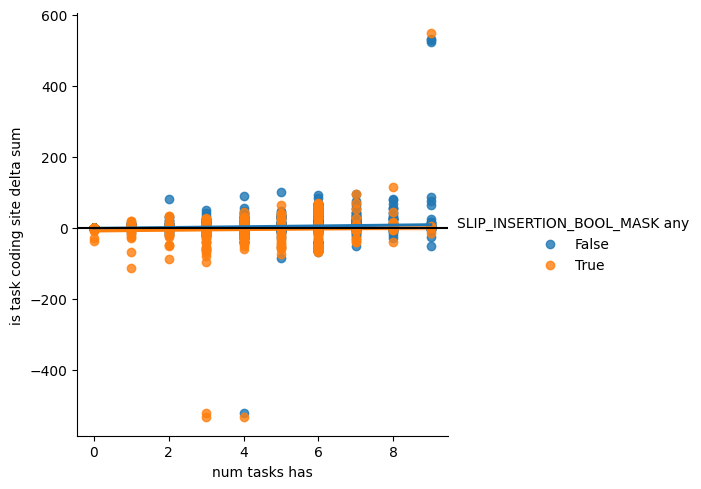

In [18]:
saveit, g = tp.tee(
    sns.lmplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    plt.gca().axhline(0, color="black")

saveit()


teeplots/col=has-complex-components+hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/col=has-complex-components+hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.png


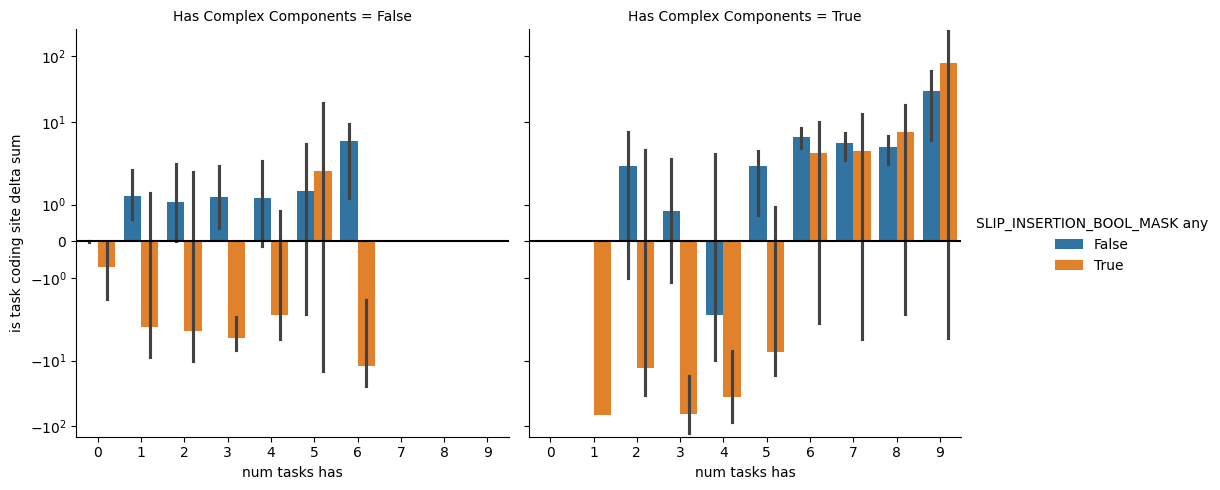

In [19]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    col="Has Complex Components",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=bar+mut=poisson+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.png


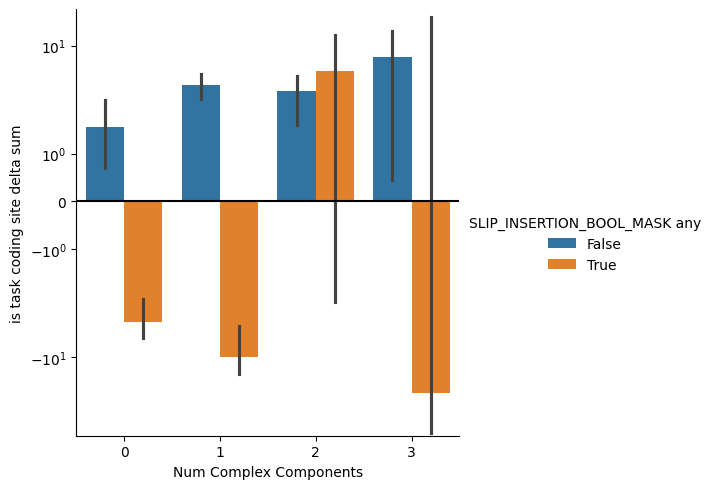

In [20]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+mut=poisson+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+mut=poisson+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.png


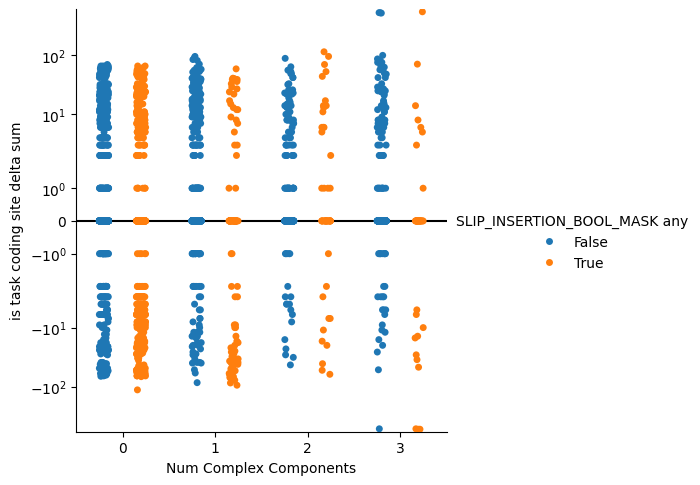

In [21]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="strip",
    dodge=True,
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas(),
    teeplot_callback=True,
    teeplot_outattrs={"mut": "poisson"},
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=num-complex-components+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+mut=poisson+stat=count+viz=displot+x=num-complex-components+ext=.png


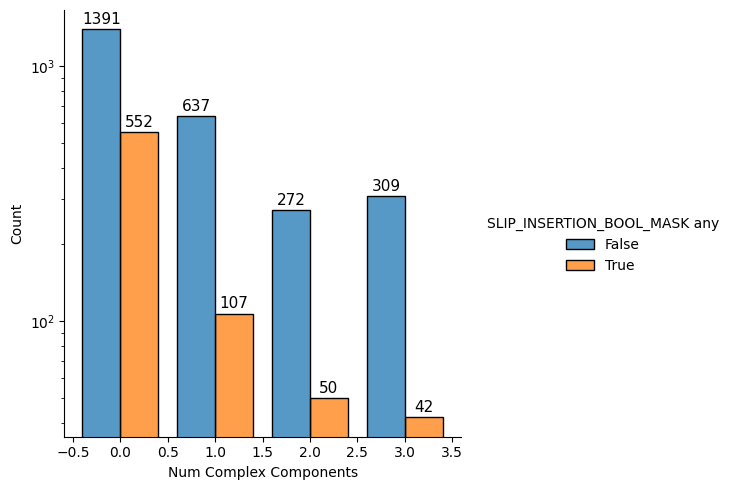

In [22]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip+",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,
    teeplot_outattrs={"mut": "poisson"},
)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()
